In [1]:
from openai import OpenAI
from matplotlib import patches
from matplotlib import pyplot as plt
import numpy as np
import PIL.Image
from pprint import pprint 

from agent_process import get_rough_crop, extract_info, get_color
from agent_tools.img_outer_border import get_image_with_border, draw_grid_on_image
from agent_tools.hough_axis import detect_axis_bounding_box, detect_axis_bounding_box_contour
from agent_tools.crop_img import crop_image
from agent_tools.plot_extract import extract_and_save_plot_points, mask_alphabetic_text

from prompts import PromptManager

from utilities.data_utils import image_to_data_url
from utilities.data_utils import image_path_to_image
from utilities.debug_tools import plot_image

from utilities.output_convert  import model_output_to_json

In [2]:
IMAGE_PATH = "test_figs/cz/fig6_5.png"
MODEL_NAME="/mnt/longcontext/models/siyuan/llama3/Qwen2.5-VL-72B-Instruct/"
client = OpenAI(api_key="token-abc123", base_url="http://127.0.0.1:8000/v1")

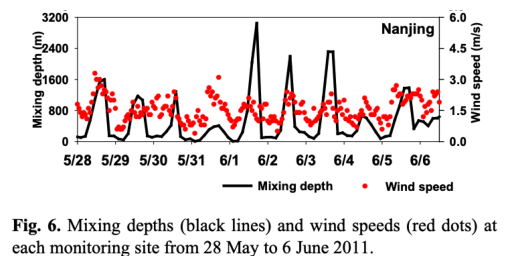

Image size: 741 x 368
Image mode: RGB
Image format: None
Image info: {'icc_profile': b'\x00\x00\x02\x08appl\x04\x00\x00\x00mntrRGB XYZ \x07\xe9\x00\x03\x00\x17\x00\x13\x000\x005acspAPPL\x00\x00\x00\x00APPL\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-appl\x13\x86\xa7\xc2Ay=*\xcdM)\x04X\xdd\x94=\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\ndesc\x00\x00\x00\xfc\x00\x00\x000cprt\x00\x00\x01,\x00\x00\x00Pwtpt\x00\x00\x01|\x00\x00\x00\x14rXYZ\x00\x00\x01\x90\x00\x00\x00\x14gXYZ\x00\x00\x01\xa4\x00\x00\x00\x14bXYZ\x00\x00\x01\xb8\x00\x00\x00\x14rTRC\x00\x00\x01\xcc\x00\x00\x00\x10chad\x00\x00\x01\xdc\x00\x00\x00,bTRC\x00\x00\x01\xcc\x00\x00\x00\x10gTRC\x00\x00\x01\xcc\x00\x00\x00\x10mluc\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x0cenUS\x00\x00\x00\x14\x00\x00\x00\x1c\x00Q\x002\x007\x00G\x002\x00G\x003\x00R\x004\x00Bmluc\x00\x00\x00\x00\x00\x00\x00\

In [3]:
image = image_path_to_image(IMAGE_PATH)
plot_image(image)

In [4]:
import cv2
def draw_grid_on_image(img, grid_size=50, color=(0, 0, 0), thickness=1)->np.ndarray:
    """
    Draw grid lines on an image using OpenCV.

    Parameters:
        img (numpy.ndarray): The input image (BGR format).
        grid_size (int): Distance between grid lines in pixels.
        color (tuple): Color of the grid lines (B, G, R).
        thickness (int): Line thickness.

    Returns:
        numpy.ndarray: Image with grid lines.
    """
    if isinstance(img, np.ndarray):
        pass
    elif isinstance(img, PIL.Image.Image):
        img = np.array(img)
    else:
        raise ValueError(f"draw_grid_on_image only accepts img type np.ndarray or PIL.Image.Image, got {type(img)} instead.")
    img_with_grid = img.copy()
    height, width = img.shape[:2]

    # Draw vertical lines
    for x in range(0, width, grid_size):
        cv2.line(img_with_grid, (x, 0), (x, height), color, thickness)

    # Draw horizontal lines
    for y in range(0, height, grid_size):
        cv2.line(img_with_grid, (0, y), (width, y), color, thickness)

    return img_with_grid

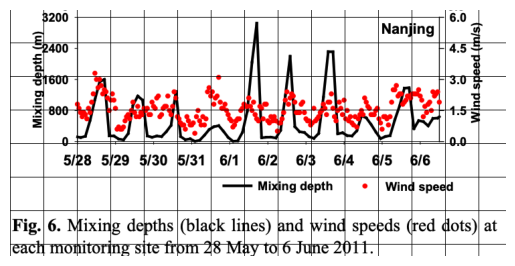

Image size: 741 x 368
Image mode: RGB
Image format: None
Image info: {}


In [5]:
plot_image(draw_grid_on_image((image)))

In [6]:
prompt_manager = PromptManager()
# prompt_manager.crop_prompt = """I will provide you with an image containing multiple charts. Your task is to identify and return the approximate bounding box coordinates (top-left and bottom-right corners) for the first chart within the image. tell me the height of the upper bound, the height of the lower bound first. Then output the bounding boxes. You are allowed to output boxes that are too big, but you can not output boxes that are too small that it didn't cover the full sub-chart. The format of the output should be a list of dictionaries, where each dictionary represents a chart and contains its coordinates in the following format:
# ```json
# [
#   {"chart_id": 1, "top_left": [x1, y1], "bottom_right": [x2, y2]}
# ]```
#  The bounding boxes can be slightly larger to ensure the entire chart is included.
#  """

In [7]:
box_message = get_rough_crop(client, image_to_data_url((image)), prompt_manager,MODEL_NAME)
print(box_message)

```json
[
  {
    "chart_id": 1,
    "top_left": [0, 0],
    "bottom_right": [643, 259]
  }
]
```


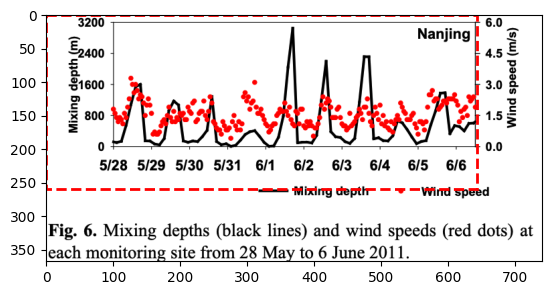

In [8]:


box_list = model_output_to_json(box_message)

fig, ax = plt.subplots()
# Display the image
img = image
ax.imshow(np.array(img))
# Create a Rectangle patch
for box in box_list:
    top_left = box["top_left"]
    bottom_right = box["bottom_right"]
    rect = patches.Rectangle(
        top_left,
        bottom_right[0] - top_left[0],
        bottom_right[1] - top_left[1],
        linewidth=2,
        edgecolor="r",
        facecolor="none",
        linestyle="--",
    )
    # draw rectangle with dashed line
    ax.add_patch(rect)
plt.show()

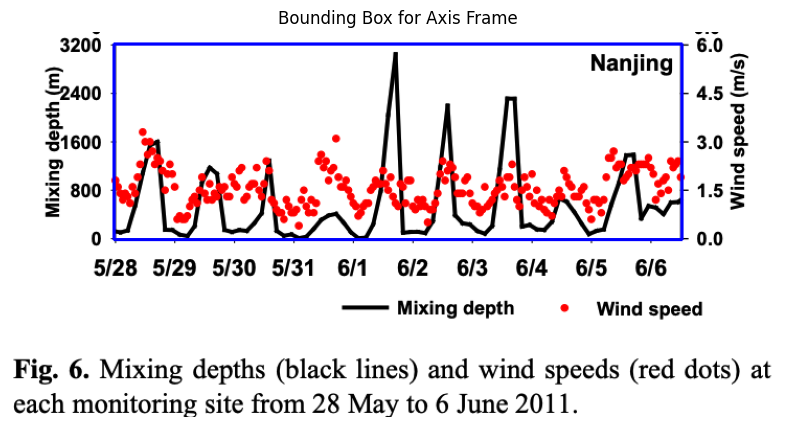

In [9]:
bounding_box = detect_axis_bounding_box(image, debug=True)

In [10]:
boxed_info = extract_info(client, image_to_data_url(image), [bounding_box], prompt_manager, MODEL_NAME)

In [11]:
boxed_info = model_output_to_json(boxed_info)
pprint(boxed_info)

[{'bottom_right': [642, 198],
  'chart_id': 1,
  'plots': [{'color': 'black',
             'name': 'Mixing depth',
             'y_axis_label': 'Mixing depth (m)',
             'y_axis_max': 3200,
             'y_axis_min': 0},
            {'color': 'red',
             'name': 'Wind speed',
             'y_axis_label': 'Wind speed (m/s)',
             'y_axis_max': 6.0,
             'y_axis_min': 0.0}],
  'title': 'Nanjing',
  'top_left': [99, 11],
  'x_axis_label': None,
  'x_axis_max': None,
  'x_axis_min': None,
  'x_axis_ticks': ['5/28',
                   '5/29',
                   '5/30',
                   '5/31',
                   '6/1',
                   '6/2',
                   '6/3',
                   '6/4',
                   '6/5',
                   '6/6'],
  'y_axis_label': ['Mixing depth (m)', 'Wind speed (m/s)'],
  'y_axis_max': [3200, 6.0],
  'y_axis_min': [0, 0.0],
  'y_axis_ticks': [[0, 800, 1600, 2400, 3200], [0.0, 1.5, 3.0, 4.5, 6.0]]}]


In [13]:
return_array

array([], dtype=float64)

In [16]:
color

{'R': 255, 'G': 0, 'B': 0}

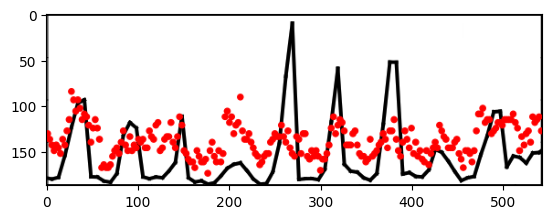

In [19]:
plt.imshow(mask_alphabetic_text(cropped_image))

Color 1: R, G, B = (255, 255, 255), Count = 80493
Color 2: R, G, B = (255, 0, 0), Count = 5154
Color 3: R, G, B = (0, 0, 0), Count = 4840
Color 4: R, G, B = (226, 226, 226), Count = 558
Color 5: R, G, B = (24, 24, 24), Count = 558
Color 6: R, G, B = (28, 28, 28), Count = 504
Color 7: R, G, B = (255, 8, 8), Count = 317
Color 8: R, G, B = (255, 4, 4), Count = 272
Color 9: R, G, B = (255, 6, 6), Count = 229
Color 10: R, G, B = (255, 7, 7), Count = 216
Color 11: R, G, B = (83, 83, 83), Count = 183
Color 12: R, G, B = (150, 150, 150), Count = 163
Color 13: R, G, B = (187, 187, 187), Count = 162
Color 14: R, G, B = (255, 9, 9), Count = 139
Color 15: R, G, B = (254, 0, 0), Count = 83
Error decoding JSON: Expecting property name enclosed in double quotes: line 5 column 1 (char 38)
retry using ast.literal_eval
Extracted points saved to output/plot_points/image_arrayMixing depth_plot_points.csv


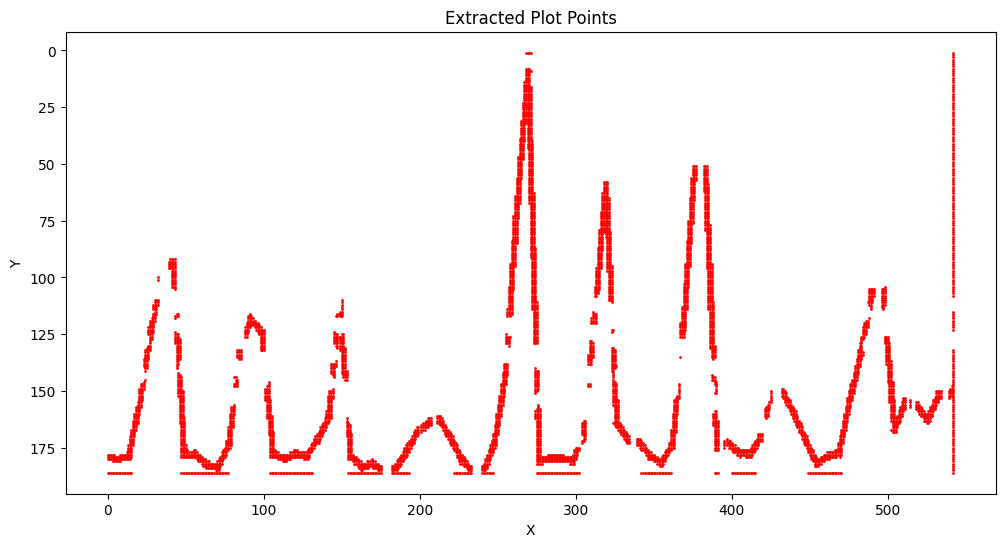

Color 1: R, G, B = (255, 255, 255), Count = 80493
Color 2: R, G, B = (255, 0, 0), Count = 5154
Color 3: R, G, B = (0, 0, 0), Count = 4840
Color 4: R, G, B = (226, 226, 226), Count = 558
Color 5: R, G, B = (24, 24, 24), Count = 558
Color 6: R, G, B = (28, 28, 28), Count = 504
Color 7: R, G, B = (255, 8, 8), Count = 317
Color 8: R, G, B = (255, 4, 4), Count = 272
Color 9: R, G, B = (255, 6, 6), Count = 229
Color 10: R, G, B = (255, 7, 7), Count = 216
Color 11: R, G, B = (83, 83, 83), Count = 183
Color 12: R, G, B = (150, 150, 150), Count = 163
Color 13: R, G, B = (187, 187, 187), Count = 162
Color 14: R, G, B = (255, 9, 9), Count = 139
Color 15: R, G, B = (254, 0, 0), Count = 83
Error decoding JSON: Expecting property name enclosed in double quotes: line 5 column 1 (char 40)
retry using ast.literal_eval
Extracted points saved to output/plot_points/image_arrayWind speed_plot_points.csv


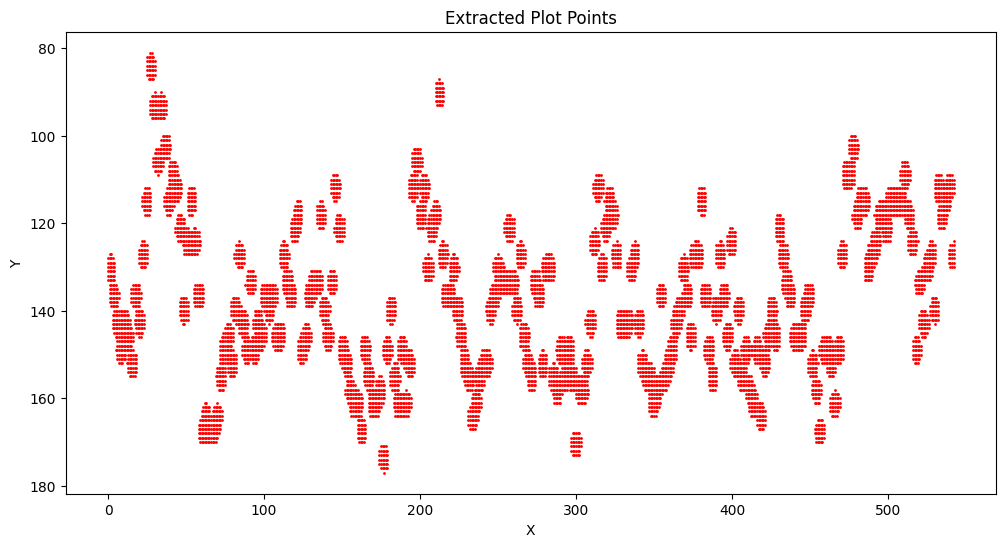

In [20]:
import pandas as pd
cropped_image = crop_image(image, bounding_box[0], bounding_box[1])
for plot in boxed_info[0]["plots"]:
        color_name = plot["color"]
        plot_name = plot["name"]
        plot_label = plot["y_axis_label"]
        color = get_color(client, cropped_image, plot["color"], model_name=MODEL_NAME)
        return_array = extract_and_save_plot_points(
            mask_alphabetic_text(cropped_image),
            target_color=(color["B"], color["G"], color["R"]),
            output_dir="output/plot_points",
            output_suffix=f"{plot_name}_plot_points",
            link_distance=10,
            legend_filter_length=100,
            debug=True
        )
        transposed_unit_array = (bounding_box[1][1]-bounding_box[0][1]-return_array[:,1])/ (bounding_box[1][1] - bounding_box[0][1]) * (plot['y_axis_max']-plot['y_axis_min']) + plot['y_axis_min']
        # concatenate the two arrays
        return_array = np.concatenate(
            (return_array, transposed_unit_array.reshape(-1, 1)),
            axis=1,
        )
        pd.DataFrame(return_array, columns=["x", "pixel space",plot_label.replace(" ", "_")]).to_csv(
            f"output/plot_points/{plot_name.replace(' ', '_')}_plot_points.csv", index=False
        )

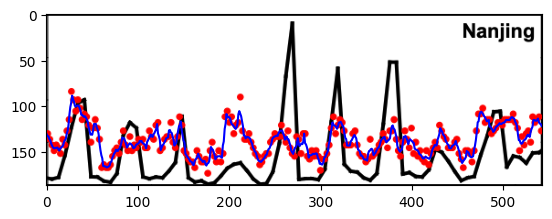

In [21]:
# plot the returned array back on the original image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# plot the cropped image
fig, ax = plt.subplots()
ax.imshow(cropped_image)
# plot the returned array
plt.plot(return_array[:, 0], return_array[:, 1], c="blue", )

In [ ]:
return_array

array([[3.00000000e+00, 1.79500000e+02, 3.07165775e+03],
       [4.00000000e+00, 1.79500000e+02, 3.07165775e+03],
       [8.00000000e+00, 1.79500000e+02, 3.07165775e+03],
       ...,
       [5.40000000e+02, 1.50500000e+02, 2.57540107e+03],
       [5.41000000e+02, 1.50000000e+02, 2.56684492e+03],
       [5.42000000e+02, 9.12906977e+01, 1.56219376e+03]])